# The Exploration of Daniel Bourke's Youtube Channel - My First Data Project

## Introduction
In this notebook, we are going to explore [Daniel Bourke's YouTube channel](https://www.youtube.com/channel/UCr8O8l5cCX85Oem1d18EezQ "mrdbourke").

Daniel Bourke is a machine learning engineer and content creator.

I came across an idea for this when I was browsing his YouTube channel. I noticed that he had two distinct topics: machine learning and fitness.

Then, the thought came to me.

I wonder how the popularity of his machine learning videos would compared to his fitness related videos. And so begins this project.

As with any project, this is a learning oppourtunity to improve my skills in coding and dealing with data. This being my first means I have lots to learn!

## Aims
- Pull data from YouTube Data API v3 to get upload playlist and the individual video statistics for Daniel Bourke's youtube channel.
- Classify his videos between machine learning and fitness/health - somehow.
- Come up with some way of visualising the difference in popularity (based on view count)

## Resources

- [Setting up Google API Client](https://developers.google.com/docs/api/quickstart/python)
- [Google Console](https://console.developers.google.com/)
- [YouTube Data API v3 Documentation](https://developers.google.com/youtube/v3)

## Let's Get Started

Most libraries are the stock standard, included in the Anaconda distribution.

You will need to install the [Google API Client library for Python](https://developers.google.com/docs/api/quickstart/python).

This can be done simply using `conda install google-api-python-client`

In addition to this, I have also included `conda install isodate`



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as r
import seaborn as sns

%matplotlib inline

import os
import requests
import math
import re
import isodate

from datetime import date, time, datetime

import googleapiclient.discovery
import googleapiclient.errors



## Access the YouTube API

You will need to head over to the [Google Console to create a project](https://console.developers.google.com/).

This will give you an API key. Make sure you copy this. I have created a seperate Python file, `setAPIkey.py` that saves the API key to an environment variable, `YT_API`. This file sits in `.gitignore` so it doesn't accidently appear on my github!

Here is the code for `setAPIkey.py`:
```python
#!python3

import os
os.environ['YT_API'] = 'xxAPI KEY HERExx'
```



In [2]:
%run setAPIkey.py

api_service_name = 'youtube'
api_version = 'v3'
youtube = googleapiclient.discovery.build(api_service_name, api_version, developerKey=os.getenv('YT_API'))



## Access the Daniel Bourke's Channel

We are going to access the upload playlist ID which contains all uploaded videos on Daniel Bourke's channel. We do this by using the `channels().list()` method.

This is going to be stored in `uploadPlaylist_ID`

[More documentation on this method, here.](https://developers.google.com/youtube/v3/docs/channels/list)



In [3]:
channel_ID = 'UCr8O8l5cCX85Oem1d18EezQ' # Daniel Bourke's channel ID

channel_request = youtube.channels().list(
    part='snippet,contentDetails',
    id=channel_ID
)
channel_res = channel_request.execute()
channel_res

{'kind': 'youtube#channelListResponse',
 'etag': 'xaqUNTC2ZtEfkWOssAXuy7EtWZo',
 'pageInfo': {'resultsPerPage': 1},
 'items': [{'kind': 'youtube#channel',
   'etag': 'hn79H0m-K3PIGztc7HX-w1XdZQo',
   'id': 'UCr8O8l5cCX85Oem1d18EezQ',
   'snippet': {'title': 'Daniel Bourke',
    'description': "I'm a machine learning engineer who plays at the intersection of technology and health.\n\nMy videos will help you learn better and live healthier.\n\nFeel free to introduce yourself, I'd love to hear from you.\n\nDaniel",
    'publishedAt': '2016-08-02T21:36:26Z',
    'thumbnails': {'default': {'url': 'https://yt3.ggpht.com/a/AATXAJwKBdy84WKVUIoOt37SBAeWjUhPdGDAx9WxNt1Rdz4=s88-c-k-c0xffffffff-no-rj-mo',
      'width': 88,
      'height': 88},
     'medium': {'url': 'https://yt3.ggpht.com/a/AATXAJwKBdy84WKVUIoOt37SBAeWjUhPdGDAx9WxNt1Rdz4=s240-c-k-c0xffffffff-no-rj-mo',
      'width': 240,
      'height': 240},
     'high': {'url': 'https://yt3.ggpht.com/a/AATXAJwKBdy84WKVUIoOt37SBAeWjUhPdGDAx9WxN

In [4]:
uploadPlaylist_ID = channel_res['items'][0]['contentDetails']['relatedPlaylists']['uploads']

## Get the list of Video IDs

Precisely as the title says, let's get those video IDs in a list. We are going to use a similiar method, `playlistItems().list()`. [More information, here](https://developers.google.com/youtube/v3/docs/playlistItems/list)

We can request 50 video IDs at a time. A `pageToken` variable is given that allows us to access the next lot of 50 videos. I'm going to write this as a funciton and call it `playlist_requester()` since I will be calling it multiple times.

In [5]:
def playlist_requester(pageToken=None,uploadPlaylist_ID=uploadPlaylist_ID):
    playlist_request = youtube.playlistItems().list(
        part='snippet,contentDetails',
        maxResults=50,
        pageToken=pageToken,
        playlistId=uploadPlaylist_ID
    )
    playlist_res = playlist_request.execute()
    
    return playlist_res



I run the function once to get the total number of videos in this playlist and the first pageToken variable.

What I also do is create a list of just the video IDs, which is the only thing relevant. I use a list comprehension to do this.



In [6]:
playlist_res = playlist_requester()

TOTAL_UPLOADS = playlist_res['pageInfo']['totalResults'] # total videos in upload playslist
nextPageToken = playlist_res['nextPageToken'] # needed to access the next page

listOfVideo_IDs = [ video_ID['contentDetails']['videoId'] for video_ID in playlist_res['items'] ] # first 50



Then, I create a while loop to get all the video IDs into a list.



In [7]:
while TOTAL_UPLOADS > len(listOfVideo_IDs):
    
    nextpage_playlist_res = playlist_requester(nextPageToken)
    listOfVideo_IDs.extend([ video_ID['contentDetails']['videoId'] for video_ID in nextpage_playlist_res['items'] 
                            if video_ID['contentDetails']['videoId'] not in listOfVideo_IDs ]) # extend() for lists / #append only does one item at ta time / concating lists with + is very intenstive according to "Python for Data Analysis"
    if 'nextPageToken' in nextpage_playlist_res:
        nextPageToken = nextpage_playlist_res['nextPageToken']
        
    print('Number of Uploaded Videos: ' + str(len(listOfVideo_IDs)))

Number of Uploaded Videos: 100
Number of Uploaded Videos: 150
Number of Uploaded Videos: 200
Number of Uploaded Videos: 250
Number of Uploaded Videos: 253


## Get the Video Statistics

Finally after all of that we get the statistics for each video. I use a for loop to run through the list generated earlier.

Similiar to `playlistItems().list()`, I can use `videos().list()` to request 50 videos at a time.

The output will combined together using another list comprehension.

We imported the `math` library earlier. We are going to use the `ceil()` function to compute the number of '50 chuncks' out of the total list, rounding up. We also use list splicing to get each '50 chunk'.

We use `pd.json_normalize()` on our newly created list `video_response` to flatten the output provided, turning it into a pandas dataframe (fun fact: in New Zealand we use British English so we are used to using 's' instead of 'z' for normalize).

`df.head()` will provide us the first 5 video and their statistics. Hooray!

In [8]:
video_response = [ youtube.videos().list(
        part='snippet,contentDetails,statistics',
        id=listOfVideo_IDs[50*i:50*(i+1)]
    ).execute() for i in range(math.ceil(len(listOfVideo_IDs)/50)) ]

df = pd.json_normalize(video_response, 'items')

df.head()

,kind,etag,id,snippet.publishedAt,snippet.channelId,snippet.title,snippet.description,snippet.thumbnails.default.url,snippet.thumbnails.default.width,snippet.thumbnails.default.height,...,contentDetails.licensedContent,contentDetails.projection,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.favoriteCount,statistics.commentCount,snippet.tags,snippet.defaultAudioLanguage,contentDetails.regionRestriction.blocked
0,youtube#video,S5Bz3tuqf2DKv0-l03LtvNFzsEs,cZ2HCclgQ-g,2020-09-13T02:30:12Z,UCr8O8l5cCX85Oem1d18EezQ,How I'd start learning machine learning again ...,Three years ago I started studying machine lea...,https://i.ytimg.com/vi/cZ2HCclgQ-g/default.jpg,120,90,...,True,rectangular,26842,1413,20,0,142,NaN,NaN,NaN
1,youtube#video,VMbRnGjPtPnsBE6VpUZ41IOImis,Nz7xzUybpFM,2020-09-06T10:58:18Z,UCr8O8l5cCX85Oem1d18EezQ,Building a Deep Learning PC,I've been thinking about building my own deep ...,https://i.ytimg.com/vi/Nz7xzUybpFM/default.jpg,120,90,...,True,rectangular,8189,350,6,0,122,NaN,NaN,NaN
2,youtube#video,SW4WtQQQCoRza699XN0hg454fuo,3IKWukTiBfc,2020-08-09T06:06:03Z,UCr8O8l5cCX85Oem1d18EezQ,The future will not be supervised... | Machine...,This month has been all about GPT3 and self-su...,https://i.ytimg.com/vi/3IKWukTiBfc/default.jpg,120,90,...,True,rectangular,7460,282,2,0,36,"[self supervised learning machine learning, ma...",NaN,NaN
3,youtube#video,FC2ufYLTPo8nOzPorT_cgNaeK18,8JTKX09LzNc,2020-08-06T00:29:48Z,UCr8O8l5cCX85Oem1d18EezQ,Are courses enough for a job? | Machine learni...,"Let's talk machine learning, health, business ...",https://i.ytimg.com/vi/8JTKX09LzNc/default.jpg,120,90,...,True,rectangular,7607,313,9,0,26,NaN,NaN,NaN
4,youtube#video,y9vZtTm7EoIH-YyCCUURGSk2BJc,ZeCReYxxDFQ,2020-07-16T03:15:13Z,UCr8O8l5cCX85Oem1d18EezQ,What does a head of data science look for in a...,Ken Jee is the head of data science at Scouts ...,https://i.ytimg.com/vi/ZeCReYxxDFQ/default.jpg,120,90,...,True,rectangular,9913,485,9,0,36,"[ken jee, daniel bourke, what questions get as...",NaN,NaN


## Exploring the Data

Let's do some exploring. We use `df.shape` to find out how many rows and columns exist in this dataframe `(rows, columns)`. The number of rows should equal the total videos uploaded on Daniel Bourke's YouTube channel since each row is one video.

We then use `df.dtypes` to see what the data types are for each column and also the explore what columns we have to play with.

In [9]:
df.shape

(253, 41)

In [10]:
df.dtypes

kind                                         object
etag                                         object
id                                           object
snippet.publishedAt                          object
snippet.channelId                            object
snippet.title                                object
snippet.description                          object
snippet.thumbnails.default.url               object
snippet.thumbnails.default.width              int64
snippet.thumbnails.default.height             int64
snippet.thumbnails.medium.url                object
snippet.thumbnails.medium.width               int64
snippet.thumbnails.medium.height              int64
snippet.thumbnails.high.url                  object
snippet.thumbnails.high.width                 int64
snippet.thumbnails.high.height                int64
snippet.thumbnails.standard.url              object
snippet.thumbnails.standard.width           float64
snippet.thumbnails.standard.height          float64
snippet.thum

We can see all the columns and data types. We can select the columns we can to keep. We also want to change them to the appropriate data type for further analysis and we can do this with `astype()`.

We can confirm this change running `dtypes()` again.

In [11]:
df1 = df[['snippet.title', 'snippet.tags', 'contentDetails.duration',
       'statistics.viewCount', 'statistics.likeCount', 'statistics.dislikeCount',
        'statistics.commentCount', 'snippet.publishedAt','snippet.description']]

df1 = df1.astype({'statistics.viewCount': 'float'})
df1 = df1.astype({'statistics.likeCount': 'float'})
df1 = df1.astype({'statistics.dislikeCount': 'float'})
df1 = df1.astype({'statistics.commentCount': 'float'})

We can also note that there are publish dates and times: `snippet.publishedAt` and `contentDetails.duration`. There need to be converted into a workable format.

In [12]:
df1['snippet.publishedAt_REFORMATED'] = df1['snippet.publishedAt'].apply(lambda x : datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ'))
df1['contentDetails.duration_REFORMATED'] = df1['contentDetails.duration'].apply(lambda x : isodate.parse_duration(x)) # Turns ISO8061 into duration that can be utilised by python

In [13]:
df1.head(2)

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt,snippet.description,snippet.publishedAt_REFORMATED,contentDetails.duration_REFORMATED
0,How I'd start learning machine learning again ...,NaN,PT26M23S,26842.0,1413.0,20.0,142.0,2020-09-13T02:30:12Z,Three years ago I started studying machine lea...,2020-09-13 02:30:12,0 days 00:26:23
1,Building a Deep Learning PC,NaN,PT1H1M46S,8189.0,350.0,6.0,122.0,2020-09-06T10:58:18Z,I've been thinking about building my own deep ...,2020-09-06 10:58:18,0 days 01:01:46


In [14]:
df1.dtypes

snippet.title                                  object
snippet.tags                                   object
contentDetails.duration                        object
statistics.viewCount                          float64
statistics.likeCount                          float64
statistics.dislikeCount                       float64
statistics.commentCount                       float64
snippet.publishedAt                            object
snippet.description                            object
snippet.publishedAt_REFORMATED         datetime64[ns]
contentDetails.duration_REFORMATED    timedelta64[ns]
dtype: object

Let's do some further exploration of the view counts. We are going to use the `matplotlib` library, along with `seaborn`.

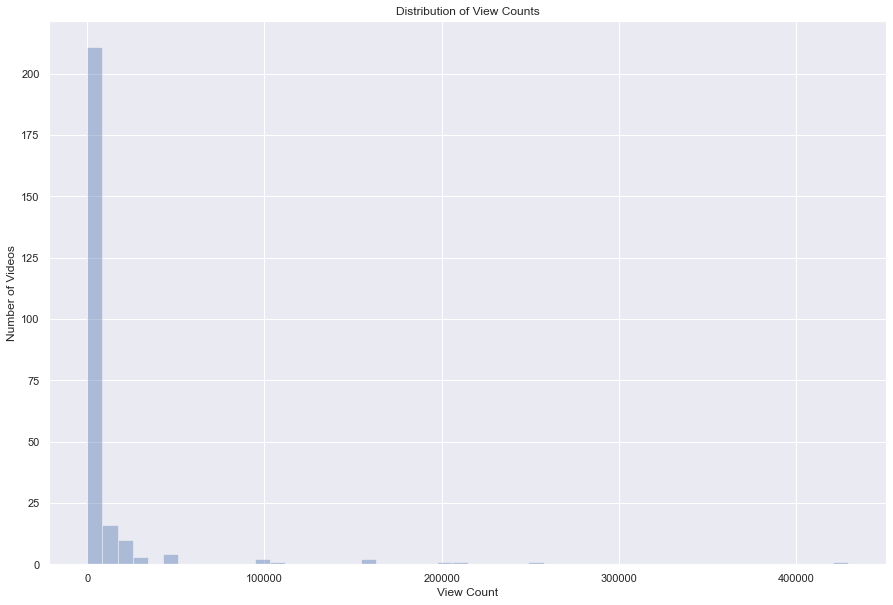

In [15]:
views = df1['statistics.viewCount']
sns.set(style='darkgrid')
plt.figure(figsize=(15,10))

ax = sns.distplot(views, kde=False)
labels = ax.set(title='Distribution of View Counts',xlabel='View Count', ylabel='Number of Videos')

We can see the majority of videos are well below 10,000 views, which goes to show how hard it is to be a content creator.

Its almost Pareto principle, where 20% or your content gives 80% of the rewards. We can confirm this:

In [16]:
vidsOver10000views = (df1['statistics.viewCount']<10000).sum()
totalVids = len(listOfVideo_IDs)
percentage = round(( vidsOver10000views * 100 ) /  totalVids,2)
print('Videos under 10,000 views: {} ({}%)'.format(str(vidsOver10000views),str(percentage)))

Videos under 10,000 views: 216 (85.38%)


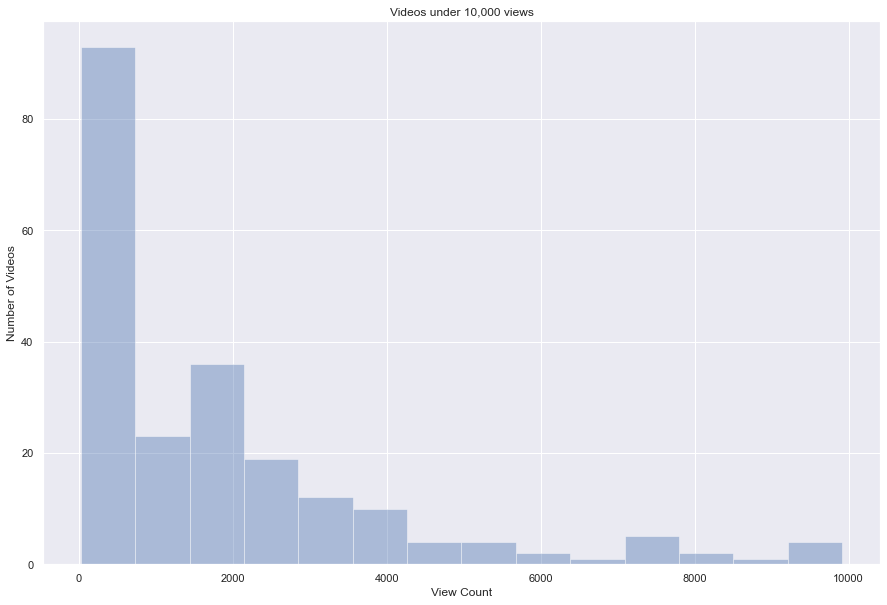

In [17]:
viewsU10000 = df1['statistics.viewCount'][df1['statistics.viewCount']<10000]
sns.set(style='darkgrid')
plt.figure(figsize=(15,10))

ax = sns.distplot(viewsU10000, kde=False)
labels = ax.set(title='Videos under 10,000 views',xlabel='View Count', ylabel='Number of Videos')

## Classifying Videos

Moving on, we need to stick to our objective of classifying those videos: machine learning vs non-machine learning (which is pretty much fitness).

We can start by looking at the tags, which are in a convinient list format, and some are empty or `NaN`.

In [18]:
df['snippet.tags'].head()

0                                                  NaN
1                                                  NaN
2    [self supervised learning machine learning, ma...
3                                                  NaN
4    [ken jee, daniel bourke, what questions get as...
Name: snippet.tags, dtype: object

In [19]:
tags = df['snippet.tags'].apply(pd.Series).stack().reset_index(drop=True).value_counts()

tagsAbove10 = tags[lambda x : x > 10]
tagsAbove10

daniel bourke                                 95
fitness                                       58
machine learning engineer                     56
learning                                      52
vlog                                          51
podcast                                       51
life                                          51
machine                                       49
entertainment                                 49
lessons                                       49
Daniel Bourke                                 48
fail                                          47
university                                    47
success                                       47
college                                       47
The Daniel Bourke Show                        47
The                                           46
Bourke                                        46
speaking                                      46
public                                        46
drop out            

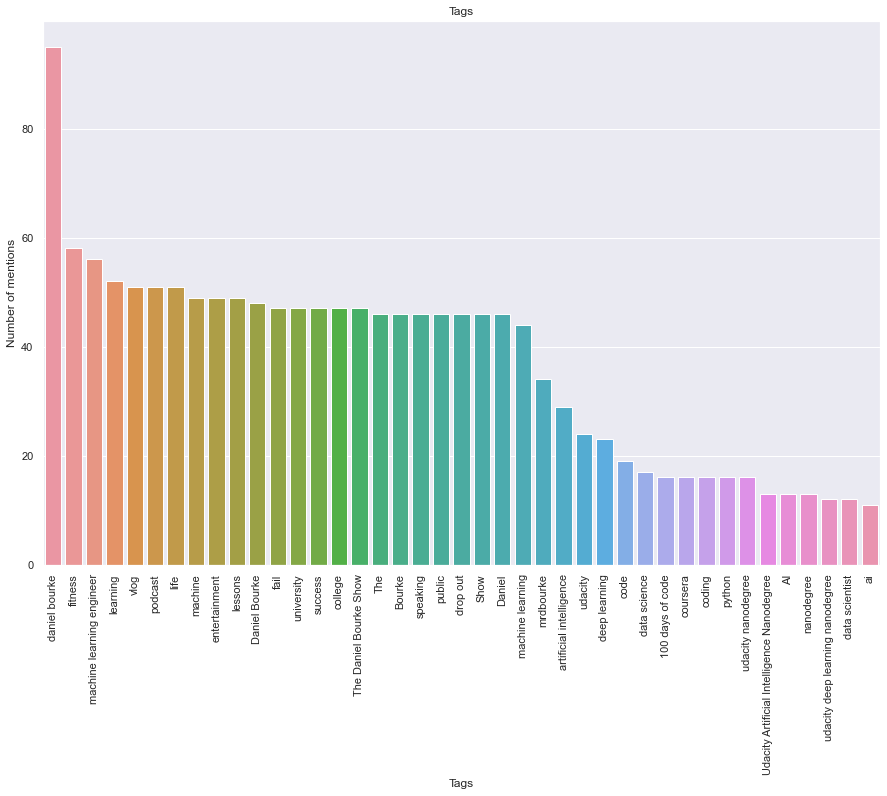

In [20]:
sns.set(style='darkgrid')
plt.figure(figsize=(15,10))

ax = sns.barplot(tagsAbove10.index, tagsAbove10.values)
ax.set(title='Tags',xlabel='Tags', ylabel='Number of mentions')
ticks = ax.set_xticklabels(ax.get_xticklabels(),rotation=90) # if not assigned to a variable, then prints lots of text

We are using `map()` function. This essential does through every cell and applies the contents, which is a lambda function, which searches the tags or title for any of the words  `pat`.

We are also going to create another column within the same dataframe, `isMachineLearning`.

In [133]:
pat = r'.*(machine learning|data science|artificial intelligence|deep learning|code|machine|python|coding|code|udacity|coursera|data scientist|tensorflow).*$'

df1['isMachineLearning'] = df1['snippet.tags'].map(lambda x : bool(re.search(pat, str(x).lower())))|df1['snippet.title'].map(lambda x : bool(re.search(pat, str(x).lower())))
df1.head(20)

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt,snippet.description,snippet.publishedAt_REFORMATED,contentDetails.duration_REFORMATED,isMachineLearning,statistics.viewCount_LOG
0,How I'd start learning machine learning again ...,NaN,PT26M23S,26842.0,1413.0,20.0,142.0,2020-09-13T02:30:12Z,Three years ago I started studying machine lea...,2020-09-13 02:30:12,0 days 00:26:23,True,10.197723
1,Building a Deep Learning PC,NaN,PT1H1M46S,8189.0,350.0,6.0,122.0,2020-09-06T10:58:18Z,I've been thinking about building my own deep ...,2020-09-06 10:58:18,0 days 01:01:46,True,9.010547
2,The future will not be supervised... | Machine...,"[self supervised learning machine learning, ma...",PT26M28S,7460.0,282.0,2.0,36.0,2020-08-09T06:06:03Z,This month has been all about GPT3 and self-su...,2020-08-09 06:06:03,0 days 00:26:28,True,8.917311
3,Are courses enough for a job? | Machine learni...,NaN,PT1H24M11S,7607.0,313.0,9.0,26.0,2020-08-06T00:29:48Z,"Let's talk machine learning, health, business ...",2020-08-06 00:29:48,0 days 01:24:11,True,8.936824
4,What does a head of data science look for in a...,"[ken jee, daniel bourke, what questions get as...",PT1H1M6S,9913.0,485.0,9.0,36.0,2020-07-16T03:15:13Z,Ken Jee is the head of data science at Scouts ...,2020-07-16 03:15:13,0 days 01:01:06,True,9.201602
5,2020 Machine Learning Roadmap,"[machine learning field guide, machine learnin...",PT2H37M14S,253198.0,13089.0,151.0,545.0,2020-07-12T15:00:12Z,Getting into machine learning is quite the adv...,2020-07-12 15:00:12,0 days 02:37:14,True,12.441927
6,One Neural Network to Rule Them All (and more)...,"[zero to mastery, machine learning monthly, wh...",PT32M2S,5552.0,198.0,0.0,62.0,2020-07-06T10:30:06Z,Every month I write an article called Machine ...,2020-07-06 10:30:06,0 days 00:32:02,True,8.621914
7,How to get experience as a beginner data scien...,NaN,PT27M56S,48595.0,1779.0,16.0,188.0,2020-07-05T06:57:22Z,"Manuela emailed the other day asking ""how can ...",2020-07-05 06:57:22,0 days 00:27:56,True,10.791276
8,How I passed the TensorFlow Developer Certific...,NaN,PT26M25S,214311.0,7558.0,92.0,532.0,2020-06-10T02:06:17Z,"At the start of May, I decided to take the Ten...",2020-06-10 02:06:17,0 days 00:26:25,True,12.275184
9,How to be more self-reliant: The Jester Physic...,"[how to be more self-reliant, the four pillars...",PT22M1S,2506.0,99.0,3.0,40.0,2020-05-31T13:15:01Z,"Like spinning plates, self-reliance is an acti...",2020-05-31 13:15:01,0 days 00:22:01,False,7.826443


In [22]:
NaNs = df1['isMachineLearning'].isna().sum()
Total_MLvids =  df1['isMachineLearning'].sum()
Total_nonMLvids = (df1['isMachineLearning']==False).sum()
Total = Total_MLvids + Total_nonMLvids

print('Total NaN: ', NaNs)
print('Total ML videos: ', Total_MLvids)
print('Total non-ML videos: ', Total_nonMLvids)
print('Videos in total: ', Total)

print('Percentage of ML videos: {}%'.format(str(round(((Total_MLvids*100)/Total),2))))

Total NaN:  0
Total ML videos:  175
Total non-ML videos:  78
Videos in total:  253
Percentage of ML videos: 69.17%


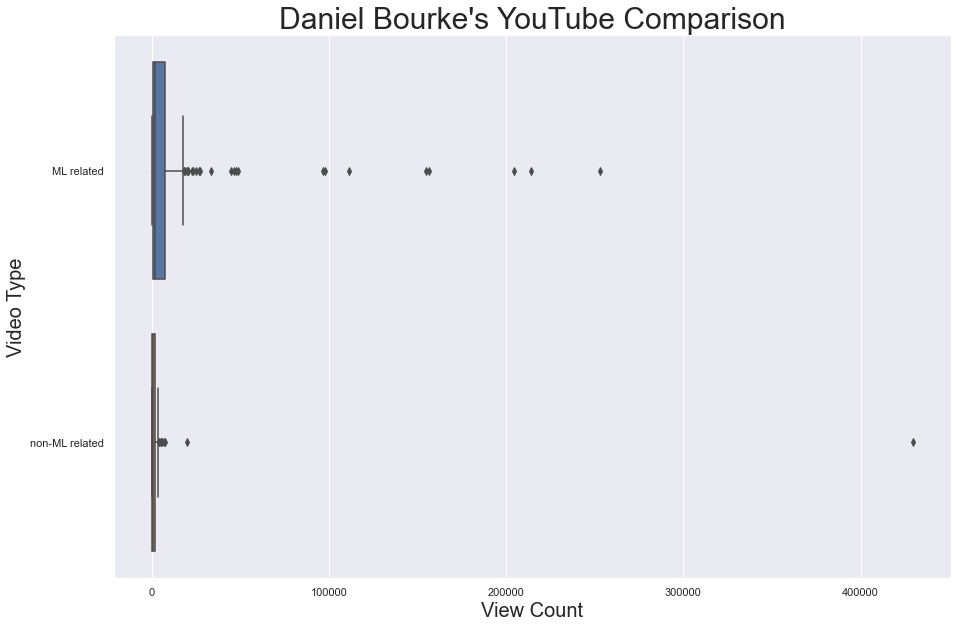

In [37]:
MLds = df1[df1['isMachineLearning']==True]['statistics.viewCount'] # create dataseries of view counts for ML related videos
nonMLds = df1[df1['isMachineLearning']==False]['statistics.viewCount']

d = {'ML related': MLds.values, 'non-ML related': nonMLds.values} # creating a dictionary to title data
d = pd.DataFrame.from_dict(d, orient='index') # dataseries have different shape or 'sizes', pandas will add NaN to make series same size

data = d.transpose()

plt.figure(figsize=(15,10))
sns.set(style='darkgrid')
ax = sns.boxplot(data=data, orient='h')

ax.set_title("Daniel Bourke's YouTube Comparison", fontsize=30)
ax.set_xlabel('View Count', fontsize=20)
ax.set_ylabel('Video Type', fontsize=20)


plt.show()

This isn't too useful as the data is so spaced out. What we can notice here is that view count show an exponential pattern. This is the 'viral' effect. What I can do is flatten this down by using the natural logarithm. I can apply this using `np.nlog()`

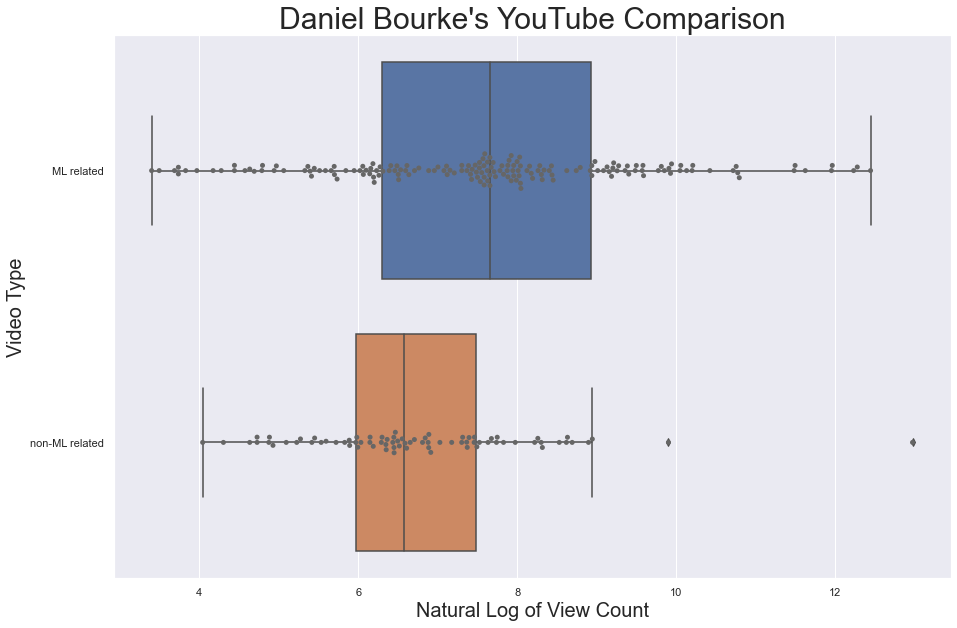

In [36]:
d = {'ML related': np.log(MLds.values), 'non-ML related': np.log(nonMLds.values)} # applying natural log
d = pd.DataFrame.from_dict(d, orient='index')

data = d.transpose()

plt.figure(figsize=(15,10))
sns.set(style='darkgrid')
ax = sns.boxplot(data=data, orient='h')

ax.set_title("Daniel Bourke's YouTube Comparison", fontsize=30)
ax.set_xlabel('Natural Log of View Count', fontsize=20)
ax.set_ylabel('Video Type', fontsize=20)

ax = sns.swarmplot(data=data, orient='h', color='0.4')

plt.show()

We can also view this as a distribution type plot, showing the two groups. Another thing to note is that the groups have different sizes.

This next plot normalises the different groups as though they are the same size.

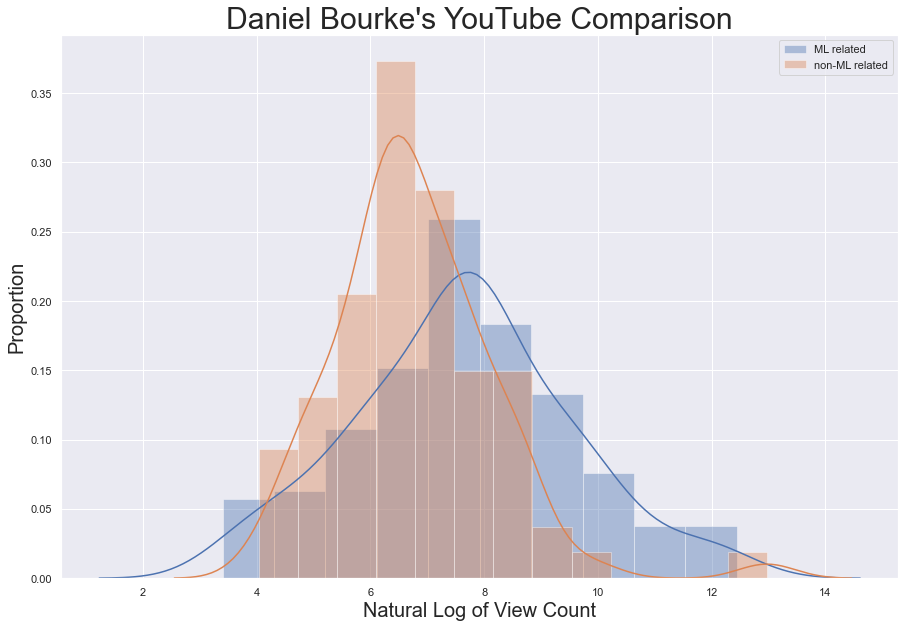

In [38]:
d = {'ML related': np.log(MLds.values), 'non-ML related': np.log(nonMLds.values)}
d = pd.DataFrame.from_dict(d, orient='index')

data = d.transpose()

plt.figure(figsize=(15,10))
sns.set(style='darkgrid')

ax = sns.distplot(data['ML related'])
ax = sns.distplot(data['non-ML related'])


ax.set_title("Daniel Bourke's YouTube Comparison", fontsize=30)
ax.set_xlabel('Natural Log of View Count', fontsize=20)
ax.set_ylabel('Proportion', fontsize=20)

plt.legend(data)

plt.show()

An interesting fact is that Daniel Bourke's most popular video is not about machine learning. This may change in the future.

In [120]:
df1.sort_values(by='statistics.viewCount', ascending=False).head(2)

,snippet.title,snippet.tags,contentDetails.duration,statistics.viewCount,statistics.likeCount,statistics.dislikeCount,statistics.commentCount,snippet.publishedAt,snippet.description,snippet.publishedAt_REFORMATED,contentDetails.duration_REFORMATED,isMachineLearning,statistics.viewCount_LOG
69,"I didn't eat food for 4 days, here's what happ...","[what is like to do an extended fast?, intermi...",PT45M41S,429291.0,4937.0,494.0,943.0,2019-09-15T12:06:12Z,"Last month, I did my first extended fast. I’d ...",2019-09-15 12:06:12,0 days 00:45:41,False,12.969890
5,2020 Machine Learning Roadmap,"[machine learning field guide, machine learnin...",PT2H37M14S,253198.0,13089.0,151.0,545.0,2020-07-12T15:00:12Z,Getting into machine learning is quite the adv...,2020-07-12 15:00:12,0 days 02:37:14,True,12.441927


Finally, I'm interested in the trends over time. We can do this my linear regression and then extracting some statistics as well.

C:\Users\Shiva\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\Shiva\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


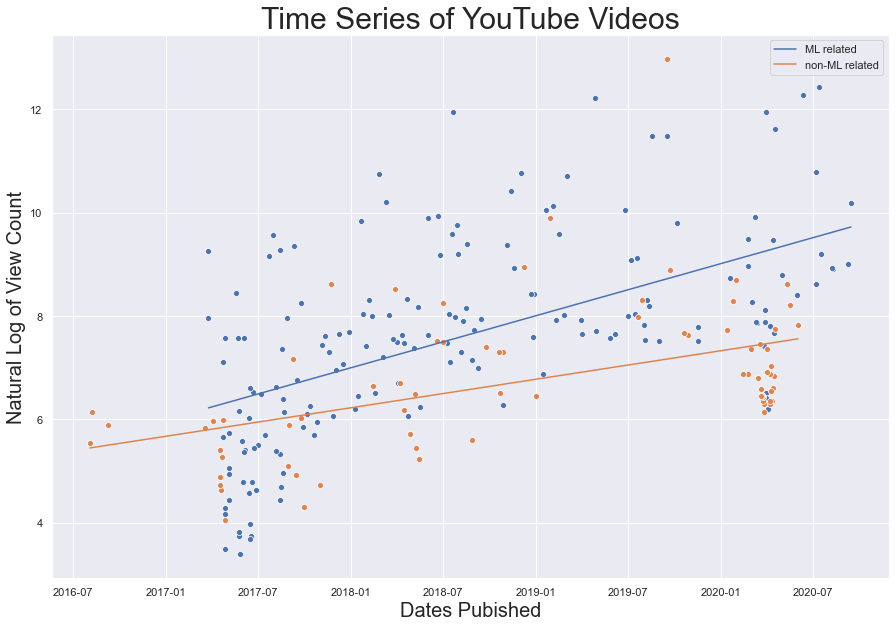

In [131]:
from sklearn.linear_model import LinearRegression

def perform_reg(X, Y):
    model = LinearRegression()
    L = len(X.values)
    X = X.values.reshape(-1,1)
    Y = Y
    model.fit(X, Y)
    return model.predict(X)

d = {'ML related': MLdf, 'non-ML related': nonMLdf}

df1['statistics.viewCount_LOG'] = df1['statistics.viewCount'].apply(lambda x : np.log(x))
MLdf = df1[df1['isMachineLearning']==True]
nonMLdf = df1[df1['isMachineLearning']==False]

MLdf['statistics.viewCount_REG'] = perform_reg(MLdf['snippet.publishedAt_REFORMATED'].map(datetime.toordinal), MLdf['statistics.viewCount_LOG'])
nonMLdf['statistics.viewCount_REG'] = perform_reg(nonMLdf['snippet.publishedAt_REFORMATED'].map(datetime.toordinal), nonMLdf['statistics.viewCount_LOG'])


plt.figure(figsize=(15,10))
sns.set(style='darkgrid')

ax = sns.scatterplot(data=MLdf,x='snippet.publishedAt_REFORMATED', y='statistics.viewCount_LOG')
ax = sns.scatterplot(data=nonMLdf,x='snippet.publishedAt_REFORMATED', y='statistics.viewCount_LOG')
ax = sns.lineplot(data=MLdf,x='snippet.publishedAt_REFORMATED', y='statistics.viewCount_REG')
ax = sns.lineplot(data=nonMLdf,x='snippet.publishedAt_REFORMATED', y='statistics.viewCount_REG')


ax.set_title("Time Series of YouTube Videos", fontsize=30)
ax.set_xlabel('Dates Pubished', fontsize=20)
ax.set_ylabel('Natural Log of View Count', fontsize=20)

plt.legend(d)

plt.show()

We can see a general upward trend in the upward trend in his view count. We can also see the consistency Daniel Bourke has put into making his channel. Consistency is key.

Another point is that we see in general greater potential in the machine learning video related content compared to the non-machine learning content.

Futher to this, we can obtain the acual gradient of the best-fit line as well as the Pearson correlation coefficient, which is a way of telling us how well the data fits with this best fit line.

In [121]:
import scipy.stats

# calculating the slope
resultsML = scipy.stats.linregress(MLdf['snippet.publishedAt_REFORMATED'].map(datetime.toordinal), MLdf['statistics.viewCount_LOG'])
resultsNonML = scipy.stats.linregress(nonMLdf['snippet.publishedAt_REFORMATED'].map(datetime.toordinal), nonMLdf['statistics.viewCount_LOG'])

print('ML video slope: '  + str(resultsML.slope).rjust(45))
print('Non-ML related video slope: ' + str(resultsNonML.slope).rjust(33))
print(' ')

ML_r = scipy.stats.pearsonr(MLdf['snippet.publishedAt_REFORMATED'].map(datetime.toordinal), MLdf['statistics.viewCount_LOG'])[0]
nonML_r = scipy.stats.pearsonr(nonMLdf['snippet.publishedAt_REFORMATED'].map(datetime.toordinal), nonMLdf['statistics.viewCount_LOG'])[0]

# calculating the coefficient
print('ML video correlation coefficient: '  + str(ML_r).rjust(24))
print('Non-ML video correlation coefficient: ' + str(nonML_r).rjust(20))

ML video slope:                         0.0027619171204583703
Non-ML related video slope:             0.0015117478413339974
 
ML video correlation coefficient:       0.5593699023261571
Non-ML video correlation coefficient:   0.4881345759602963


## Conclusion

I think I will leave it there. There is lots of work that can be done but this is the limit of my skills.

I hope to revisit this in the future as I get better and see what more I can do.

What I would like to improve upon is:
- an ability to classify videos
- this is really an analysis, no machine learning was used

Thank you for reading through this, please get in touch. I'm always looking to improve.
